# Implementation of Sentiment Analysis Model

## 1. Data Preprocessing

In [2]:
### Import necessary libraries

import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pickle

In [3]:
# download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
# load the dataset
data = pd.read_csv('dataset/train_data.csv', header=None, names=['text', 'label'],
                   sep=',', quotechar='"', escapechar='\\')

In [5]:
# clean the text
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # convert to lowercase
    text = text.lower()

    # tokenize and remove stopwords
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    return ' '.join(filtered_tokens)

In [6]:
# apply cleaning to all texts
data['cleaned_text'] = data['text'].apply(clean_text)

In [7]:
# split into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    data['cleaned_text'],
    data['label'],
    test_size=0.2,
    random_state=42
)

## 2. Model Training

In [8]:
# convert text to features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [9]:
# train Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

## 3. Evaluation

In [10]:
# predict on test set
y_pred = model.predict(X_test_tfidf)

In [11]:
# calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.8810
Precision: 0.8664
Recall: 0.8982
F1-score: 0.8820


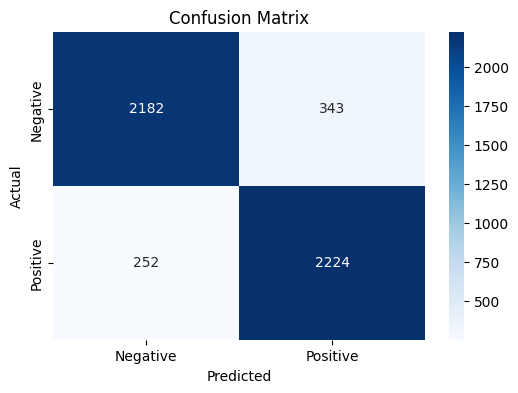

In [12]:
# confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [13]:
# save the trained model and vectorizer for future use
with open('output/sentiment_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('output/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

## 4. Demo Script

In [14]:
# demo scripts
def predict_sentiment(text):
    # load the saved model and vectorizer
    with open('output/sentiment_model.pkl', 'rb') as f:
        loaded_model = pickle.load(f)
    with open('output/tfidf_vectorizer.pkl', 'rb') as f:
        loaded_vectorizer = pickle.load(f)

    # clean the input text
    cleaned_text = clean_text(text)

    # vectorize the text
    text_tfidf = loaded_vectorizer.transform([cleaned_text])

    # predict sentiment
    prediction = loaded_model.predict(text_tfidf)[0]
    sentiment = "Positive" if prediction == 1 else "Negative"

    return sentiment

In [15]:
# example usage
test_text = "This movie was absolutely fantastic, I loved every minute of it!"
print(f"Text: {test_text}")
print(f"Predicted Sentiment: {predict_sentiment(test_text)}")

test_text = "The film was terrible, with bad acting and a boring plot."
print(f"Text: {test_text}")
print(f"Predicted Sentiment: {predict_sentiment(test_text)}")

Text: This movie was absolutely fantastic, I loved every minute of it!
Predicted Sentiment: Positive
Text: The film was terrible, with bad acting and a boring plot.
Predicted Sentiment: Negative


## 6. Using the demo script

In [16]:
# usage of demo script
print('Comment about the movie:')
user_comment = input()
print(f"Predicted Sentiment: {predict_sentiment(user_comment)}")

Comment about the movie:
This film is a masterpiece. The acting is superb, the plot is intricate and compelling, and the cinematography is breathtaking. It's a thought-provoking and emotional journey that stays with you long after the credits roll.
Predicted Sentiment: Positive


## 7. Plot Sigmoid function of our trained model

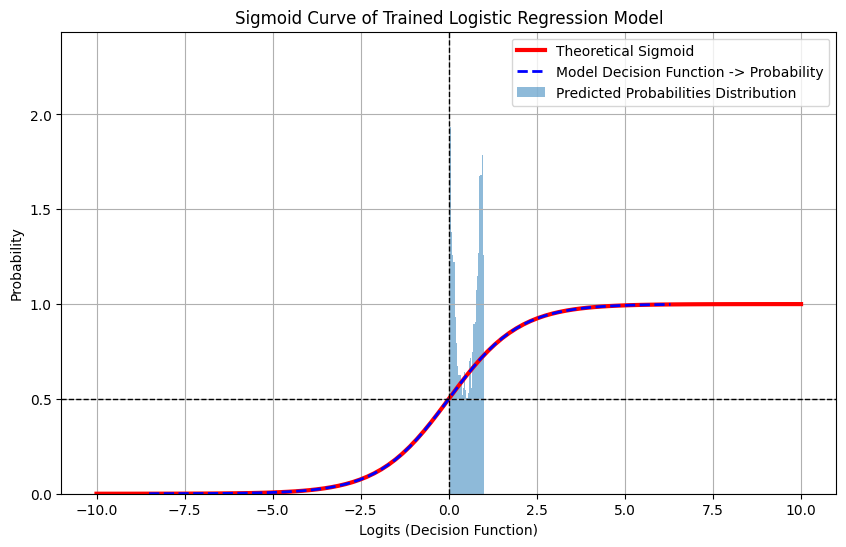

In [17]:
import numpy as np
from scipy.special import expit  # Sigmoid function

# load the existing model
with open('output/sentiment_model.pkl', 'rb') as f:
        loaded_model = pickle.load(f)

# get the model's predicted probabilities for the test set
y_probs = loaded_model.predict_proba(X_test_tfidf)[:, 1]  # probability of positive class

# sort the probabilities for better visualization
sorted_probs = np.sort(y_probs)

# # # create the sigmoid curve visualization
plt.figure(figsize=(10, 6))

# plot actual sigmoid function
x = np.linspace(-10, 10, 100)
plt.plot(x, expit(x), 'r-', label='Theoretical Sigmoid', linewidth=3)

# plot our model's decision function (logits) vs probabilities
decision_function = loaded_model.decision_function(X_test_tfidf)
sorted_logits = np.sort(decision_function)
plt.plot(sorted_logits, expit(sorted_logits), 'b--',
         label='Model Decision Function -> Probability', linewidth=2)

# plot histogram of predicted probabilities
plt.hist(y_probs, bins=30, density=True, alpha=0.5,
         label='Predicted Probabilities Distribution')

# add labels and title
plt.xlabel('Logits (Decision Function)')
plt.ylabel('Probability')
plt.title('Sigmoid Curve of Trained Logistic Regression Model')
plt.legend()
plt.grid(True)

# add vertical line at decision boundary (0.5 probability)
plt.axvline(x=0, color='k', linestyle='--', linewidth=1)
plt.axhline(y=0.5, color='k', linestyle='--', linewidth=1)

plt.show()

## 8. Evaluating trained model performace under fully new `test_data`

In [18]:
# load the test dataset
test_data = pd.read_csv('dataset/test_data.csv', header=None, names=['text', 'label'],
                   sep=',', quotechar='"', escapechar='\\')

In [19]:
# apply cleaning to all texts
test_data['cleaned_text'] = test_data['text'].apply(clean_text)

In [20]:
# split into train (10%) and test(90%) set
# because we are going to check how well our trained model to classify correctly.
# we will only use test set for evaluating, hence we take 90% as test set
X_train_set, X_test_set, y_train_set, y_test_set = train_test_split(
    test_data['cleaned_text'],
    test_data['label'],
    test_size=0.9,
    random_state=42
)

In [21]:
# convert text to features using TF-IDF
X_test_data_tfidf = tfidf_vectorizer.transform(X_test_set)

In [22]:
# predict on test set
# load the trained model
with open('output/sentiment_model.pkl', 'rb') as f:
        loaded_model_ = pickle.load(f)

y_pred_set = loaded_model_.predict(X_test_data_tfidf)

In [23]:
# calculate metrics
accuracy = accuracy_score(y_test_set, y_pred_set)
precision = precision_score(y_test_set, y_pred_set)
recall = recall_score(y_test_set, y_pred_set)
f1 = f1_score(y_test_set, y_pred_set)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.8771
Precision: 0.8731
Recall: 0.8822
F1-score: 0.8776


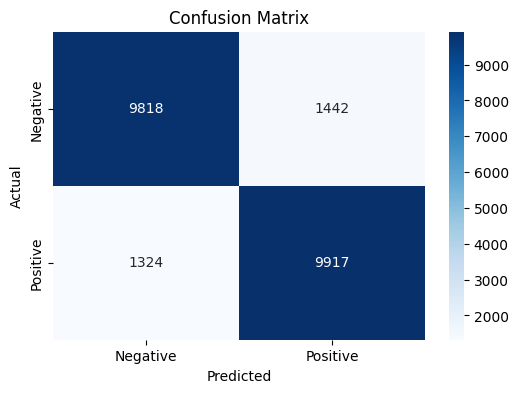

In [24]:
# confusion matrix visualization
cm = confusion_matrix(y_test_set, y_pred_set)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### 8.1 Sigmoid Curve of Trained Logistic Regression Model (on original test_data.csv)

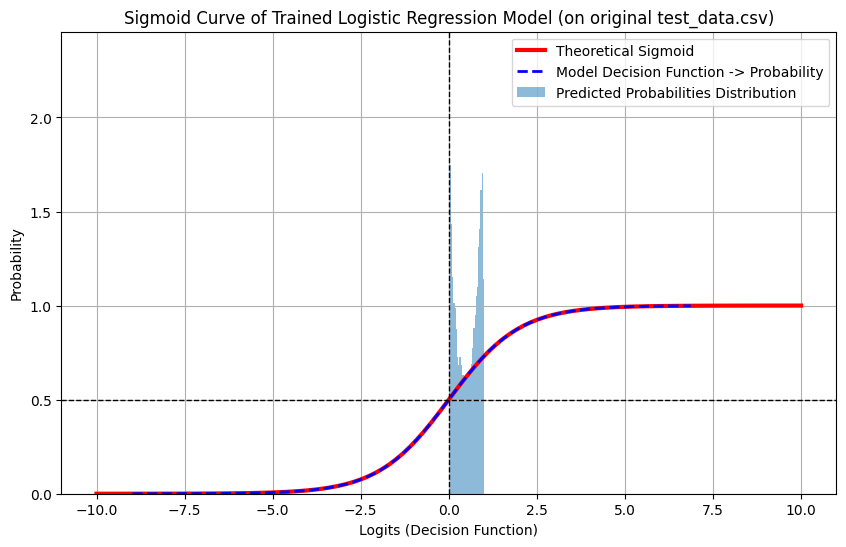

In [26]:
import numpy as np
from scipy.special import expit  # Sigmoid function

# load the existing model
with open('output/sentiment_model.pkl', 'rb') as f:
        loaded_model__ = pickle.load(f)

# get the model's predicted probabilities for the test set
y_probs_ = loaded_model__.predict_proba(X_test_data_tfidf)[:, 1]  # probability of positive class

# sort the probabilities for better visualization
sorted_probs = np.sort(y_probs_)

# # # create the sigmoid curve visualization
plt.figure(figsize=(10, 6))

# plot actual sigmoid function
x = np.linspace(-10, 10, 100)
plt.plot(x, expit(x), 'r-', label='Theoretical Sigmoid', linewidth=3)

# plot our model's decision function (logits) vs probabilities
decision_function = loaded_model__.decision_function(X_test_data_tfidf)
sorted_logits = np.sort(decision_function)
plt.plot(sorted_logits, expit(sorted_logits), 'b--',
         label='Model Decision Function -> Probability', linewidth=2)

# plot histogram of predicted probabilities
plt.hist(y_probs_, bins=30, density=True, alpha=0.5,
         label='Predicted Probabilities Distribution')

# add labels and title
plt.xlabel('Logits (Decision Function)')
plt.ylabel('Probability')
plt.title('Sigmoid Curve of Trained Logistic Regression Model (on original test_data.csv)')
plt.legend()
plt.grid(True)

# add vertical line at decision boundary (0.5 probability)
plt.axvline(x=0, color='k', linestyle='--', linewidth=1)
plt.axhline(y=0.5, color='k', linestyle='--', linewidth=1)

plt.show()